# LIGO noise curve

This notebook will show how to plot a LIGO noise curve, and how noise can hide parts of a signal.

## Sources of noise

Sources of noise in LIGO are described in the paper [Sensitivity and Performance of the Advanced LIGO Detectors in the Third Observing Run](https://arxiv.org/abs/2008.01301)

In general, there are many sources of noise, some of which are not well understood.  As a demonstration, here we will make a cartoon model of LIGO noise, which ignores many important effects.  For a more realistic model, please refer to [published papers](https://arxiv.org/abs/2008.01301).

Cartoon model:

**Shot noise**: At high frequencies, the LIGO noise curve is dominated by shot noise.  These are uncertainties on the number of photons hitting the photo detector, as dictated by the Heisenbergh uncertainty limit.  

**Thermal noise**: Thermal noise is due to the thermal vibrations of molecules within the coatings on the mirrors or the suspensions holding the mirrors.  Near 100 Hz, this is dominated by thermal motion in the coatings, which falls as roughtly (1/f^0.5).

**Controls noise:** This category is really a combination of lots of noise sources at low frequencies, including seismic noise, radiation pressure noise, and noise sources from the limits of our ability to control the position of the mirrors (controls noise).  Though this is a complicated category which includes many sources, we will model it as falling as (1/f^8), which provides an OK fit to the noise we see at low frequencies.

## Create a cartoon model of the noise

In [8]:
# -- For google co-lab
! pip install -q pycbc gwpy

import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
# -- Define an array or frequencies
freqs = np.arange(10,2048)

# -- Make a cartoon model of LIGO noise
controls = 4e-12*(1/freqs**8)
thermal = 3e-23*(1/freqs**0.5)
shot = 3.5e-24*(np.sqrt(1+(freqs/500)**2))
cartoon_asd = np.sqrt(controls**2+shot**2+thermal**2)

<ipython-input-9-b595a533abaf>:5: RuntimeWarning: divide by zero encountered in true_divide
  controls = 4e-12*(1/freqs**8)


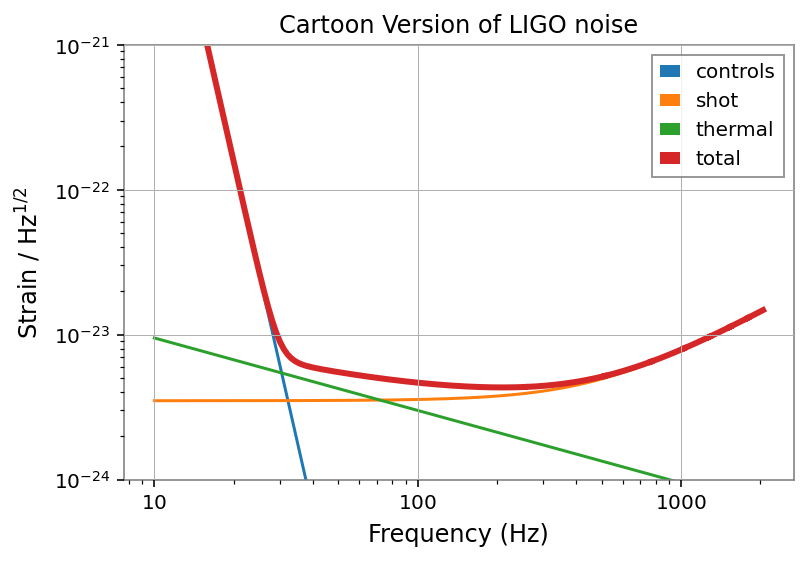

In [10]:
# -- Plot the cartoon model
plt.loglog(freqs, controls, label='controls')
plt.loglog(freqs, shot, label='shot')
plt.loglog(freqs, thermal, label='thermal')
plt.loglog(freqs, cartoon_asd, linewidth=3, label='total')
plt.ylim(1e-24, 1e-21)
plt.title('Cartoon Version of LIGO noise')
plt.ylabel('Strain / Hz$^{1/2}$')
plt.xlabel('Frequency (Hz)')
plt.legend()

## Compare the cartoon model with real LIGO noise

The ampitude of each model has been tuned to the noise.  So, getting a good fit here isn't really a confirmation of the model, but just a demonstration to help understand how to interpert a LIGO noise curve.

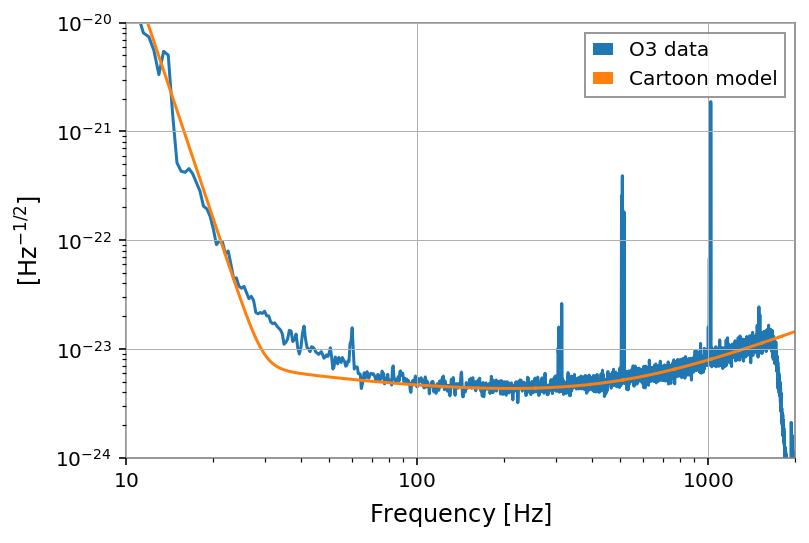

In [11]:
# -- Get some data from O3
t0 = 1249852257.0
strain = TimeSeries.fetch_open_data('L1', t0-14, t0+14, cache=False)

# -- Plot the ASD, along with the cartoon model
asd = strain.asd(fftlength=2)
asd.plot(label='O3 data')
plt.xlim(10,2000)
plt.loglog(freqs, cartoon_asd, label='Cartoon model')
plt.ylim(1e-24, 1e-20)
plt.legend()

## Hidden by noise

Because the LIGO noise curve depends on frequency, some parts of a CBC signal may be hidden by noise.  For example, notice that there is very high noise at low frequencies (f < 20 Hz).  This means that, at early times in the merger, the low frequency content may be hidden by noise.  Let's see how this looks in an example.

#### Make a  CBC waveform

In [15]:
fs = 4096
apx = 'SEOBNRv2'
hp, hc = get_td_waveform(approximant=apx,
                                 mass1=10,
                                 mass2=10,
                                 delta_t=1.0/fs,
                                 distance = 700,
                                 f_lower=20)

# -- Load the signal into a gwpy TimeSeries object
cbc = TimeSeries(hp, dt=1/fs, t0 = 1).taper()

#### Add the signal to real noise and make some plots

(20, 1000)

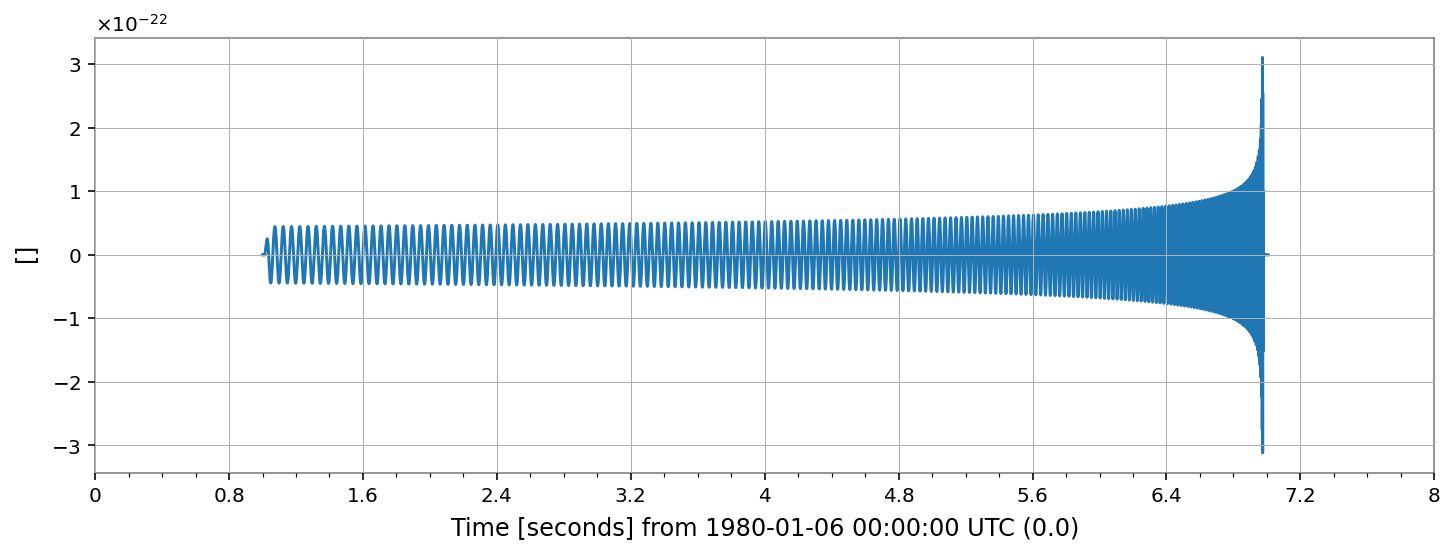

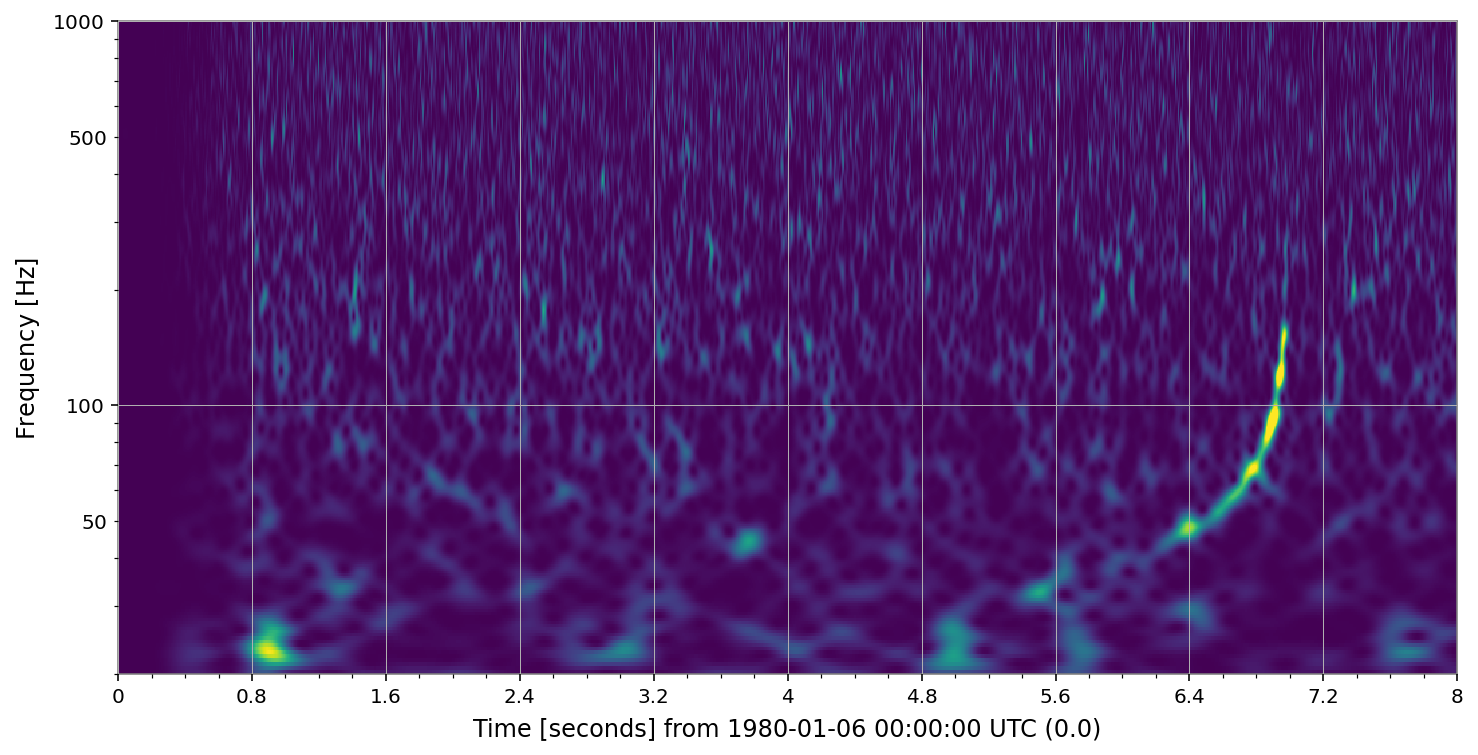

In [13]:
# -- Inject signal into real noise
strain.t0 = 0
data = strain.inject(cbc)

# -- Make a time-domain plot
cbc.plot(xlim=(0,8))

# -- Plot the spectrogram
plot = data.q_transform(outseg=(0,8), qrange=(10,30)).plot(vmax=25, vmin=0)
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 1000)

## Noise hides the early part of the signal

In the plots above, notice that in the time-domain plot of just the signal, the signal lasts from t = 1 to t = 7 seconds.  But, in the spectrogram, you can only see it for the last second before merger.  Why?  At early times (before t = 6 s), the frequency is too low, so the signal is "hidden" by the noise.  We can see this by plotting the noise and the signal in the frequency domain.

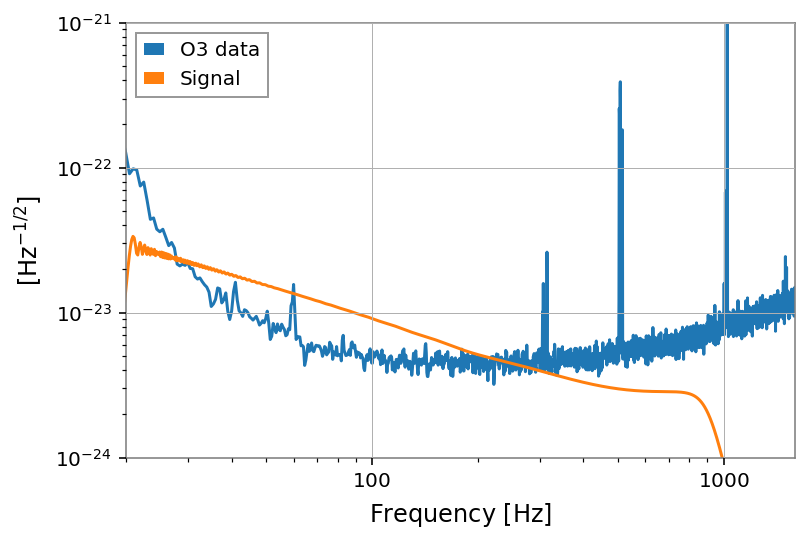

In [14]:
source_fft = cbc.fft()
np.abs(source_fft)

asd.plot(label='O3 data')
plt.xlim(20,1600)
plt.ylim(1e-24, 1e-21)
f = source_fft.frequencies
plt.loglog(f, np.abs(source_fft)*np.sqrt(f), label='Signal')
plt.legend()

In the plot above, notice that the signal is only above the noise level from around 30 Hz to 200 Hz.  In the spectrogram, you can only "see" the signal in about this frequency range.

## Check questions

1. At about what frequency is LIGO most sensitive?  This is the frequency where the noise level is the lowest.

1. Of the three noise sources in our cartoon model, which is loudest at low frequencies?  What source is loudest at high frequencies?

1. A real merging black hole orbits for millions (or billions) of years before merging.  Why, then, are signals only visible to LIGO for a few seconds or less?



# Chck answers
1. ~200 Hz
2. Low frequencies: control; high frequencies: shot
3. 